<a href="https://csdms.colorado.edu/wiki/ESPIn2020"><img style="float: center; width: 75%" src="../espin/media/ESPIn.png"></a>

# Frost-Cracking 2D

**Goal:** Calculate a bedrock frost cracking index across a landscape using real temperature data.

**Motivation:** Frost cracking of bedrock is a form of mechanical weathering that is important for landscape development in alpine and high-latitude areas, and supplies debris for rockfalls. The process at work is freeze/thaw, temperature (among other factors, such as water content) drives frost cracking. This lab explores the effect of temperature on both *frost cracking intensity* and *frost cracking depth*. Understanding where on a landscape frost cracking occurs can help us predict rockfall hazards, while exploring how frost cracking changes with temperature is important for predicting these hazards as climate warms in the future. 

**Frost Cracking in Bedrock:** In this exercise, we will determine frost-cracking intensities using the theory of [Anderson, 1998](https://www.jstor.org/stable/1552008?origin=crossref&seq=1#metadata_info_tab_contents). Anderson states that frost cracking occurs in the *frost cracking temperature window* between temperatues of -8 and -3 °C. The *frost-cracking intensity* is then related to the amount of time that bedrock spends within the frostcracking window. 

**Method:**

1. Import a DEM
2. Map DEM to grid
3. Import temperature time-series. Here, we use data from the Paleoclimate Model Intercomparison Project 6, but any timeseries can be used. 
4. Solve the 1-D heat equation (in depth dimension) at each grid node for the timeseries length
5. Determine how much time each depth at each node spends in the frost cracking window. 

First, we'll take a look at solving the 1-D heat equation. 

# 1-D Heat Diffusion

We base our heat diffusion calculation on the [Soil Temperature Profile Lab](https://csdms.colorado.edu/wiki/Lab-0010) in the EKT repository. We implement the finite-difference (numerical solution) to the heat diffusion equation in the depth demension. The heat diffusion equaiton is as follows (see the Soil Temperature Profile Lab for full derivation): 

$\boxed{\frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial z^2}}$.

The *thermal diffusivity*, $\kappa$, defined as:

$\kappa = \frac{k}{\rho C}$.

A typical thermal diffusivity for soil or rock is on the order of $10^{-6}$ m$^2$/s.


First, we import the necessary modules:

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from landlab import RasterModelGrid
from landlab import imshow_grid
import rasterio as rio
import rasterio.plot
from netCDF4 import Dataset
from landlab.io.netcdf import read_netcdf
from IPython import display

Now we need to set up the computational grid. We will use a raster. `Lx` and `Ly` are the depth and height of the bedrock domain, respectively.

In [3]:
rows = 10
cols = 30
dx = 100 # in m
rg = RasterModelGrid((rows, cols), xy_spacing=dx)

Assign fields.

In [4]:
dem = rg.add_zeros('topographic__elevation', at='node')
Ts_ini = rg.add_zeros('temperature_surface_ini', at='node')

We will simply assume a vertical wall and assign a slope along the columns of `dem`.

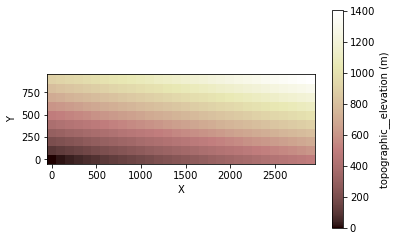

In [5]:
slope = np.deg2rad(10) # degrees
for i in range(rows):
    dem[i*cols:(i+1)*cols] = i * dx

dz = np.arange(0, np.sin(slope)*(dx*cols), np.sin(slope)*(dx*cols)/cols)
for i in range(rows):
    dem[i*cols:(i+1)*cols] += dz
    
imshow_grid(rg, 'topographic__elevation', colorbar_label='topographic__elevation (m)')

The initial surface temperature `Ts_init` needs to be extrapolated. Assumptions:
 
 - `Ts`is sinusoidal
 - lapse rate `lr` = 6 °C/km.
 - Provide the temperature mean `Tm` and the amplitude `Ta` and the representative elevation `T_ele`

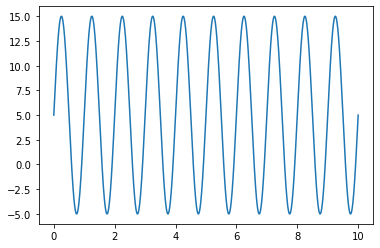

In [6]:
Tm = 5
Ta = 10
lr = 6
T_ele = 700

one_day = 60*60*24
one_year = 365 * one_day
timestep = 0.5 * 60*60 # 0.5 hours
tend = 10 * one_year
period = one_year
t = np.arange(0, tend, timestep)

Ts = Tm + Ta * np.sin(2*np.pi * t/period)
plt.plot(t/one_year,Ts)

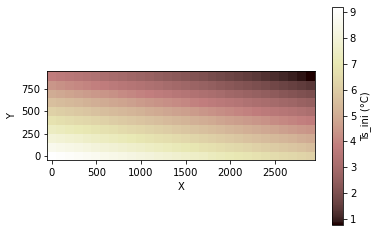

In [7]:
dz = dem - T_ele
Ts_ini[:] = Tm - dz/1000 * lr
imshow_grid(rg, 'temperature_surface_ini', colorbar_label='Ts_ini (°C)')

## The Frost-cracking model

First, we set up the model. This is based on the lab [Simulation of ground temperature profile evolution](https://csdms.rc.colorado.edu/user/jhirschberg/notebooks/learning-with-1d-models/ground_temperature_profile.ipynb). 

In [8]:
class FROST_CRACK_2D():
    
    def __init__(self,
                 path_temp_file,
                 grid_cols=30,
                 grid_rows=10,
                 grid_dx=100,
                 grid_slope=10,
                 use_dem = True,
                 dem_path = '',
                 temp_lapse_rate = -0.006,
                 thermal_diffusivity=1.0e-6,
                 profile_depth=10.0,
                 geotherm=0.025,
                 num_nodes=101,
                 lat=78.2232,
                 lon=15.6267
                ):
        """Initialize the HeatConductionSimulator.

        Parameters
        ----------
        path_temp_file: string
            path to netcdf file with temperature
        surface_temp: float
            Time series of temperature, degrees C
        time: float
            Time array, seconds
        thermal_diffusivity: float
            Thermal diffusivity, in m2/s (default 10^-6)
        profile_depth: float
            Depth of profile, m (default 1 m)
        geotherm: float
            Background geothermal gradient (default 0.025 deg C / m)
        num_nodes: int
            Number of nodes (default 101)
        diffusion_number: float
            Dimensionless diffusion number = D dt / dz^2 (default 0.2)
        """
        
        
        
        
        
        
        ######## TEMPORARY
#         Tm = 5
#         Ta = 10
#         lr = 6
#         T_ele = 700

#         one_day = 60*60*24
#         one_year = 365 * one_day
#         timestep = 0.5 * 60*60 # 0.5 hours
#         tend = 10 * one_year
#         period = one_year
#         t = np.arange(0, tend, timestep)
#         Ts = Tm + Ta * np.sin(2*np.pi * t/period)
        
        #########
        
        ### SETUP GRID
        if use_dem:
            # load dem with path
            dem_file = rio.open(dem_path) 
            dem_data = dem_file.read()
            dem_data[dem_data<-100] = np.nanmean(dem_data) # filling gaps
            dem_shape = dem_data.shape
            self.grid_rows = dem_shape[1]
            self.grid_cols = dem_shape[2]
            rg = RasterModelGrid((self.grid_rows, self.grid_cols), xy_spacing=grid_dx)
            self.elevation = dem_data[0]
            self.grid = rg
            self.T_ele = np.mean(dem_data) # 
            
            
        else:
            rg = RasterModelGrid((grid_rows, grid_cols), xy_spacing=grid_dx)
            
            slope = np.deg2rad(grid_slope) # degrees
            for i in range(rows):
                dem[i*cols:(i+1)*cols] = i * dx

            dz = np.arange(0, np.sin(slope)*(dx*cols), np.sin(slope)*(dx*cols)/cols)
            for i in range(rows):
                dem[i*cols:(i+1)*cols] += dz
                    
            dem = rg.add_zeros('topographic__elevation', at='node')
            Ts_boundary = rg.add_zeros('temperature_surface_boundary', at='node')
            
            self.grid_rows = grid_rows
            self.grid_cols = grid_cols
            self.grid_dx = grid_dx
            self.grid_slope = grid_slope
            self.dem = dem
            self.Ts_boundary = Ts_boundary
            self.grid = rg
            
        ### LOAD NETCDF FILE
        
        #ts_file = Dataset('data/ts_Eday_MPI-ESM1-2-LR_lgm_r1i1p1f1_gn_18500101-18691231.nc')
        ts_file = Dataset(path_temp_file)
        ts_lat = np.argmin(np.abs(ts_file.variables['lat'][:] - lat))
        ts_lon = np.argmin(np.abs(ts_file.variables['lon'][:] - (360 + lon)))
       
        t = ts_file.variables['time'][:] # time
        self.Ts_org = ts_file.variables['ts'][:, ts_lat, ts_lon] # surface temp
    
        self.Ts_org -= 273.15
        
        # interpolate
        # it is now in days since ...
        self.t_org_unit = ts_file.variables['time'].units
        self.t_org_start = ts_file.variables['time'][0]
        t = (t - t[0])*24*60*60 # make it start from 0
        tnew = np.arange(0,t[-1],3600) # hourly time step
        Ts_new = np.interp(tnew, t, self.Ts_org)
        self.Ts = Ts_new
        
        #### Set depth and time steps
        
        self.time = tnew
        self.dz = profile_depth / (num_nodes - 1)
        self.timestep_duration_should = self.dz * self.dz /(2*thermal_diffusivity) # Von Neumann stability
        self.timestep_duration_is = self.time[1]-self.time[0]
        assert self.timestep_duration_should > self.timestep_duration_is
        
        # scale temperature with elevation
        self.temp_lapse_rate = temp_lapse_rate
        #self.Ts0 = self.Ts[0]
        self.Ts_ini = np.mean(self.Ts) # take the mean for initialization
        Ts0_ele = self.Ts_ini + self.temp_lapse_rate*(self.elevation - self.T_ele)
        self.Ts0_ele = np.repeat(Ts0_ele[:, :, np.newaxis], num_nodes, axis=2)
        
        # calculate temp along geothermal gradient
        self.depth = np.linspace(0, profile_depth, num_nodes)
        geotherm_grad = geotherm * self.depth
        geotherm_matrix = np.tile(geotherm_grad, (self.grid_rows, self.grid_cols, 1))
        
        self.temp = self.Ts0_ele + geotherm_matrix
        
        self.frostcrackA = np.zeros_like(self.temp)
        self.frostcrackHR = np.zeros_like(self.temp)
        
       # self.temp = Ts[0] + geotherm * self.depth # this is the initial temperature profile
        self.geotherm = geotherm
        self.thermal_diffusivity = thermal_diffusivity
        self.num_nodes = num_nodes
        self.current_time = 0.0
        self.current_timestep = 0
        self.max_act_layer_depth = 0.0
            
    def interp_Ts(self):
        dz = self.dem - self.Ts0_ele
        self.Ts_boundary[:] = Tm - dz/1000 * lr
        pass
        # Allie did this above.
        
    def run_one_step(self):
        """Advance for one time step"""
        x, y = 500, 400 # only one cell because so slow, this is random, we use the original temp
        if self.current_timestep==0:
            self.temp[x,y,:] = np.mean(self.Ts_org) + self.geotherm * self.depth
        
        # assign boundary condition
        self.Ts_ini = self.Ts[self.current_timestep] # take the mean for initialization
        #Ts0_ele = self.Ts_ini + self.temp_lapse_rate*(self.elevation - self.T_ele)
        #self.Ts0_ele = np.repeat(Ts0_ele[:, :, np.newaxis], self.num_nodes, axis=2)
        self.temp[x,y,0] = self.Ts_ini
        
        q = -self.thermal_diffusivity * np.diff(self.temp[x,y,:])/self.dz
        #self.temp[:,:,1:-1] = self.temp[:,:,1:-1] - self.timestep_duration_is*np.diff(q)/self.dz
        self.temp[x,y,1:-1] = self.temp[x,y,1:-1] - self.timestep_duration_is*np.diff(q)/self.dz
        
        #self.temp[0] = self.surface_temp[self.current_timestep]
        #q = -self.thermal_diffusivity * np.diff(self.temp)/self.dz
        #self.temp[1:-1] = self.temp[1:-1] - self.timestep_duration_is*np.diff(q)/self.dz  
        self.current_time += self.timestep_duration_is
        self.current_timestep += 1
        
        cond1 = self.temp[x,y,:] > -8
        cond2 = self.temp[x,y,:] < -3
        self.frostcrackA[x,y,:][cond1 & cond2] += 1/(3600*24*365)
        
        self.x=x
        self.y=y
        
    def calculate_frost_cracking_depth_Anderson(self):
        for node in range(self.grid.number_of_nodes):
            pass
        # 1) following Anderson (1998)
        # time spent in the frost cracking window
        
        # for now only one cell
        
        
        
    def calculate_frost_cracking_depth_Hales_Roering(self):
        for node in range(self.grid.number_of_nodes):
            pass
        # 2) following Hales & Roering (2007)

In [9]:
#path_temp_file = 'data/ts_Eday_MPI-ESM1-2-LR_lgm_r1i1p1f1_gn_18500101-18691231.nc'
fc = FROST_CRACK_2D(path_temp_file = 'data/ts_Amon_MIROC-ES2L_lgm_r1i1p1f2_gn_320001-329912.nc',
                   dem_path = 'data/brooks_range_dem')

# Temperature 

We get the temperature series used to drive the model from the [PMIP6](https://www.wcrp-climate.org/modelling-wgcm-mip-catalogue/cmip6-endorsed-mips-article/1064-modelling-cmip6-pmip) paleoclimate models. Here, we've chosen a simulation from the Last Glacial Maximum. We then extract a timeseries from the grid cell we're interested in using the lat/long of our study area. The temperature timeseries used is shown below (note that the years are plotted incorrectly):

Text(0, 0.5, 'Temperature (°C)')

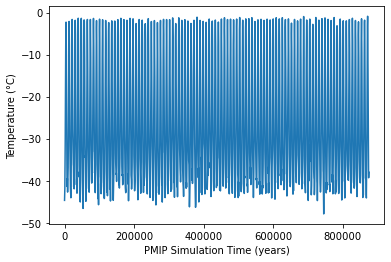

In [10]:
plt.plot(fc.Ts, )
plt.xlabel('PMIP Simulation Time (years)')
plt.ylabel('Temperature (°C)')

# DEM 

We used the following DEM to drive our model and mapped this DEM to a grid. 


<function matplotlib.pyplot.show(*args, **kw)>

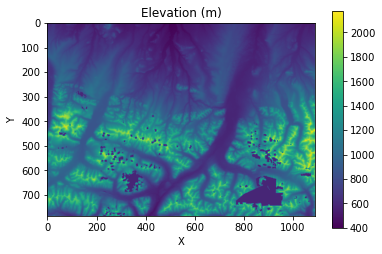

In [18]:
plt.imshow(fc.elevation)
plt.colorbar()
plt.title('Elevation (m)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show

# Initial Surface Temperature 

We assumed that the temperature series applies to the mean elevation of our study area, so we scaled the temperature with elevation using a lapse rate of 6°C/km. Here's what the initial temperature field looks like across our landscape. 

<function matplotlib.pyplot.show(*args, **kw)>

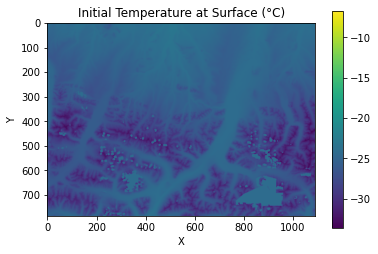

In [19]:
plt.imshow(fc.temp[:,:,0])
plt.colorbar()
plt.title('Initial Temperature at Surface (°C)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show

# Geothermal Heat Flux

The geothermal heat flux (0.025 °C/m) is used as the lower boundary condition. We set the intitial temperature profile using the intitial surface temperature and the geothermal heat flux (shown at one location):

<function matplotlib.pyplot.show(*args, **kw)>

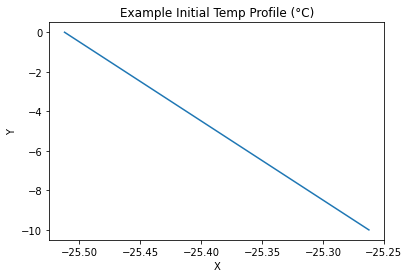

In [20]:
plt.plot(fc.temp[300, 600, :], -fc.depth)
plt.title('Example Initial Temp Profile (°C)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show

... and check that the difference between the surface temperature and the lower boundary condition is the same everywhere:

<function matplotlib.pyplot.show(*args, **kw)>

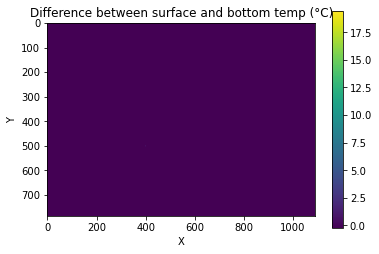

In [21]:
diff_top_bottom = fc.temp[:,:,0] - fc.temp[:,:,-1]

plt.imshow(diff_top_bottom)
plt.colorbar()
plt.title('Difference between surface and bottom temp (°C)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show

# Solving the Heat Equation 

Now, we run our model! Because this takes a long time to run, we just determined heat diffusion over our timeseries at one node, shown below. Note the frost-cracking window shown in blue

KeyboardInterrupt: 

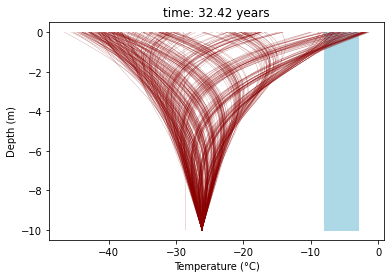

In [11]:
while fc.current_timestep < len(fc.Ts):
    #print(fc.current_timestep)
    if fc.current_time%(8760*60*60/12)==0:
        plt.plot(fc.temp[500,400,:], -fc.depth, lw=.3, alpha=.5, c='darkred', label='Temp')
        plt.fill_between([-3,-8], 0, -10, color='lightblue', label='Frost-cracking window')
        plt.ylabel('Depth (m)')
        plt.xlabel('Temperature (°C)')
        plt.title('time: %.2f years'%(fc.current_time/(8760*60*60)))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
    
    fc.run_one_step()

# Calculating Frost-Cracking Intensity

Finally, we calculate the the frost-cracking intensity by evaluating how much time is spent at each depth in the frost-cracking window. 

Text(0, 0.5, 'Depth (m)')

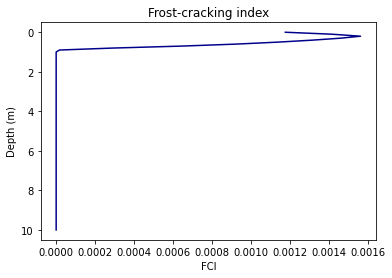

In [23]:
plt.plot(fc.frostcrackA[500,400,:], fc.depth, color='darkblue')
plt.gca().invert_yaxis()
plt.title('Frost-cracking index')
plt.xlabel('FCI')
plt.ylabel('Depth (m)')